##  Congratulations, you are now hired as a sport analytic. Your job is to give prediciton for the next Mathball tournament of the Six finest mathematicians in the world, which is a competition between Laplace, Gauss, Newton, Euler, Leibniz, Von-Neumann.

## The mathball is just like football where a player a goal is legal only after scoring you answer correctly a math question. 

## Motivation:  
### We want to infer a latent parameter - that is the 'strength' of a mathematician based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team.


In [10]:
# imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pickle as pkl

## The input   looks like as follows: 

In [11]:
group = 8
df_all  = pkl.load(open('../data_mathball/mathball_data_group_' + str(group)+ '.pkl', 'rb'))
df_all.head()

,home_player,away_player,home_score,away_score,year
0,Newton,Leibniz,31,10,1897
1,Von-Neumann,Newton,29,6,1897
2,Von-Neumann,Leibniz,23,15,1897
3,Leibniz,Laplace,20,21,1897
4,Newton,Euler,26,24,1897


## We have home and away team, we have score and year. 

## What do we want to infer?

### We want to infer the latent parameters (every mathematian's strength) that are generating the data we observe (the scorelines).
### Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.

## What do we want?

### We want to quantify our uncertainty
### We want to also use this to generate a model
### We want the answers as distributions not point estimates

## Part 1

### We next do some exploratory data analysis. The idea is to get a general sense of what is going on.

## Tasks

### 1. Plot a bar chart of the goal difference (i.e., total scored minus total scored against) per mathematician. Who is the best mathematician and who is the worst according to this plot?
### 2. Plot the same bar chart for each mathematician  as a function of time. Do you see a monote behvaoir which implies an improvement or the other way around for one of mathematician?
### 3. Choose your favorite mathematician, compare the goal difference between home and away games. Is he better in home or away games? Plot a bar chart of the goal difference for both home and away games.
### 4. Which mathematician has the best median away results? (that is, for each mathematician go over all of his away games, compute his scoring difference (how much he scored minues got scored against) and compute the median value). 

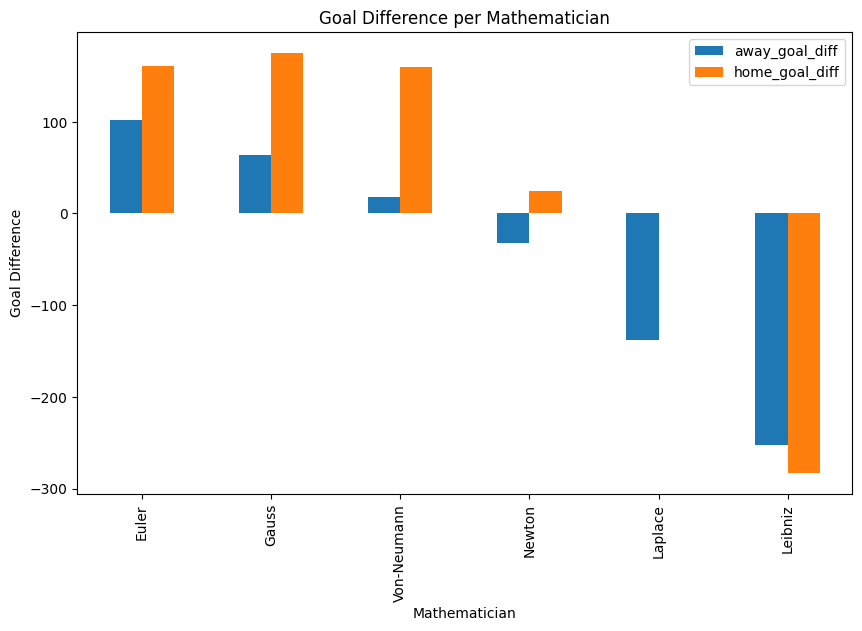

In [12]:
# Calculate goal difference per mathematician
df_all['home_goal_diff'] = df_all['home_score'] - df_all['away_score']
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

home_goal_diff = df_all.groupby('home_player')['home_goal_diff'].sum().reset_index()
away_goal_diff = df_all.groupby('away_player')['away_goal_diff'].sum().reset_index()

goal_diff = home_goal_diff.set_index('home_player').add(away_goal_diff.set_index('away_player'), fill_value=0)

# Plot the bar chart
goal_diff.sort_values(by='away_goal_diff', ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Goal Difference per Mathematician')
plt.xlabel('Mathematician')
plt.ylabel('Goal Difference')
plt.show()

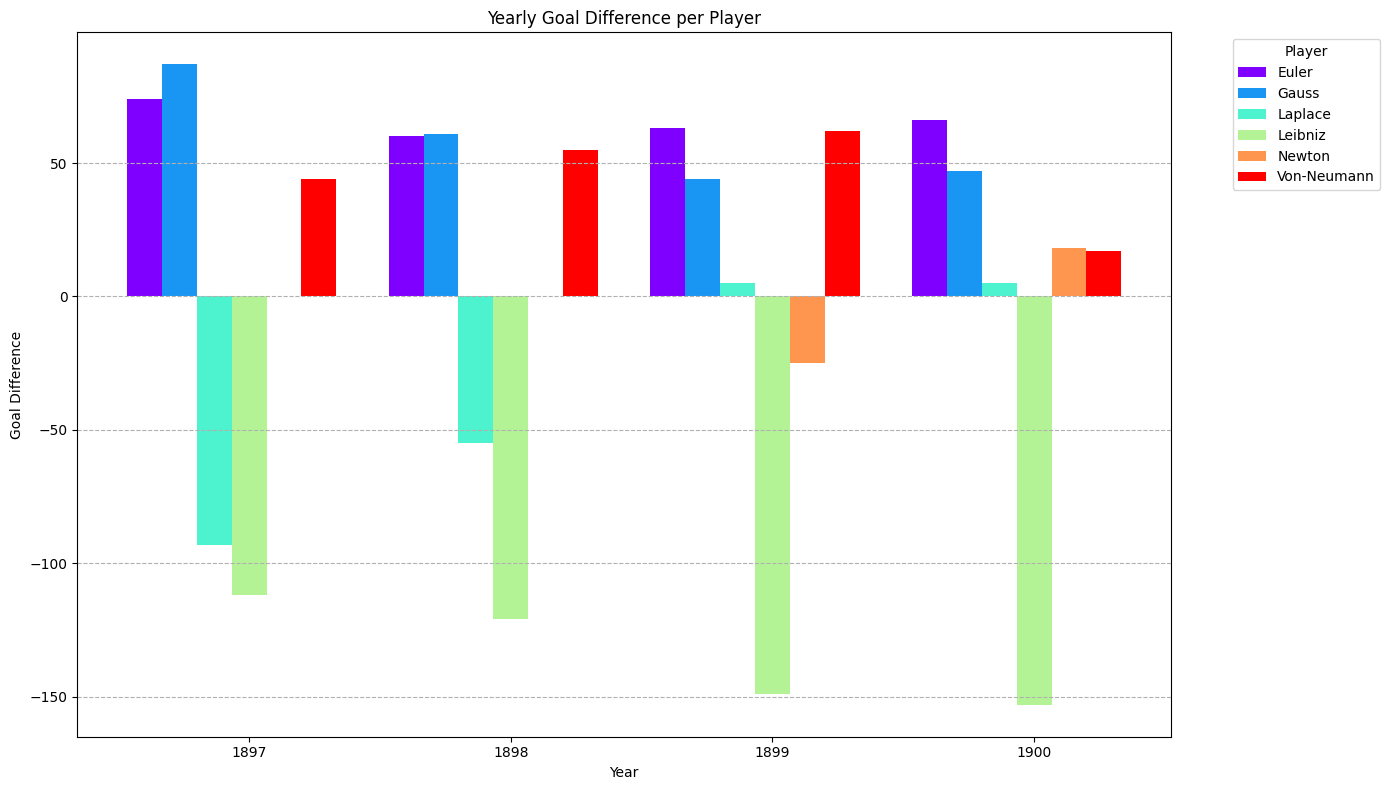

In [13]:
# Calculate goal difference per year for each mathematician
df_all['home_goal_diff'] = df_all['home_score'] - df_all['away_score']
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']
df_all['year'] = pd.to_datetime(df_all['year'], format='%Y').dt.year

home_yearly_goal_diff = df_all.groupby(['home_player', 'year'])['home_goal_diff'].sum().reset_index()
away_yearly_goal_diff = df_all.groupby(['away_player', 'year'])['away_goal_diff'].sum().reset_index()

home_yearly_goal_diff.columns = ['player', 'year', 'goal_diff']
away_yearly_goal_diff.columns = ['player', 'year', 'goal_diff']

# Combine home and away goal differences and group by player and year
yearly_goal_diff = pd.concat([home_yearly_goal_diff, away_yearly_goal_diff]).groupby(['player', 'year']).sum().reset_index()

# Unique players and years for plotting
players = yearly_goal_diff['player'].unique()
years = sorted(yearly_goal_diff['year'].unique())
n_players = len(players)
colors = plt.cm.rainbow(np.linspace(0, 1, n_players))  # Assign a unique color to each player

# Initialize figure
plt.figure(figsize=(14, 8))

# Determine the width of each bar so that all bars for a given year fit without overlapping
bar_width = 0.8 / n_players

# Plot bars for each player
for i, player in enumerate(players):
    player_data = yearly_goal_diff[yearly_goal_diff['player'] == player]
    # Calculate bar positions
    positions = [year + (i - n_players / 2) * bar_width for year in years]
    plt.bar(positions, player_data['goal_diff'], width=bar_width, label=player, color=colors[i])

# Set x-ticks to be the middle of the groups of bars
plt.xticks(years, [str(year) for year in years])

plt.title('Yearly Goal Difference per Player')
plt.xlabel('Year')
plt.ylabel('Goal Difference')
plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


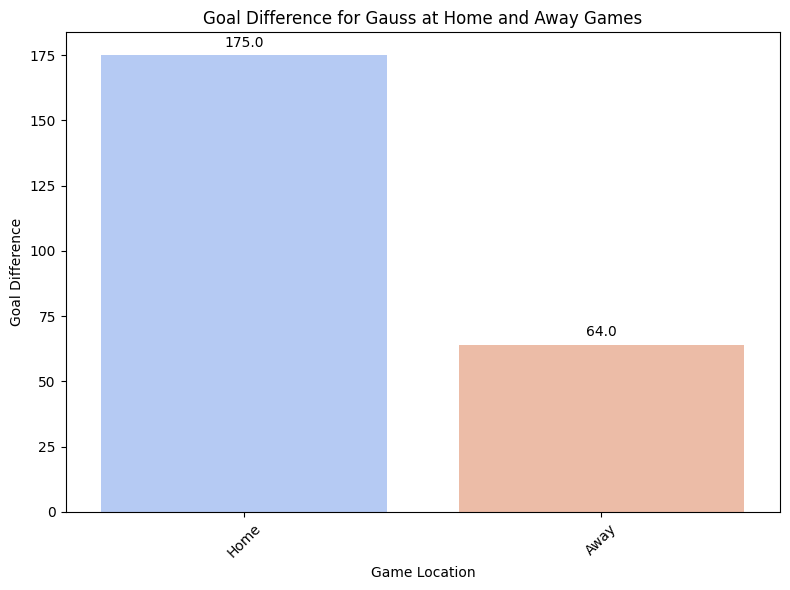

In [14]:
favorite_mathematician = 'Gauss'  # Choose your favorite mathematician

# Calculate home and away goal difference for the favorite mathematician
home_goal_diff_fav = df_all[df_all['home_player'] == favorite_mathematician]['home_goal_diff'].sum()
away_goal_diff_fav = df_all[df_all['away_player'] == favorite_mathematician]['away_goal_diff'].sum()

goal_diff_fav = pd.DataFrame({
    'Location': ['Home', 'Away'],
    'Goal Difference': [home_goal_diff_fav, away_goal_diff_fav]
})

# Plotting
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Location', y='Goal Difference', data=goal_diff_fav, palette='coolwarm')

# Add value labels on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.title(f'Goal Difference for {favorite_mathematician} at Home and Away Games')
plt.xlabel('Game Location')
plt.ylabel('Goal Difference')
plt.xticks(rotation=45)  # In case of longer labels
plt.tight_layout()
plt.show()

In [15]:
# Task 4: Determine the mathematician with the best median away results

# Calculate median away goal difference for each mathematician
median_away_goal_diff = df_all.groupby('away_player')['away_goal_diff'].median().reset_index()
median_away_goal_diff.columns = ['mathematician', 'median_away_goal_diff']

# Determine the mathematician with the highest median away goal difference
best_median_away_mathematician = median_away_goal_diff.loc[median_away_goal_diff['median_away_goal_diff'].idxmax()]

print(f"The mathematician with the best median away results is {best_median_away_mathematician['mathematician']} with a median away goal difference of {best_median_away_mathematician['median_away_goal_diff']}.")

The mathematician with the best median away results is Euler with a median away goal difference of 5.5.


## Part 2

## What assumptions do we know for our mathball competition?

### We know that there are 6 mathematicians, each year all possible pairs playes once.  
### We have data from the last few years
### We also know that in sports scoring is modelled as a Poisson distribution (even in mathball)
### We consider home advantage to be a strong effect in sports 

## The model.

### The league is made up by a total of T= 6 mathematicians, playing each other once in a season.

### We indicate the number of goals scored by the home and the away player in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
### The vector of observed goal counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
## $$y_{gj}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$$
### where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

## We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
### $$ log \theta_{g1} = intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)} $$
### $$ log \theta_{g2} = intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}$$


## Alternitevly: 

### $$  \theta_{g1} = e^{intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)}} $$
### $$  \theta_{g2} = e^{intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}}$$

### $\hat{att}_{h(g)}$ is the attack effect of a player. 
### $\hat{def}_{h(g)}$ is the attack effect of a player. 

### For mathematician  i = 1, ..., 6, both  $\hat{att}_{i}$ and $\hat{def}_{i}$ are normalized values, fomrally:

### $$ \hat{att}_{i} = att_i - \bar{att} $$
### $$ \hat{def}_{i} = att_i - \bar{def} $$

where, 

### $$ \bar{att}  = \frac{\sum_{i=1}^6 att_i}{6} $$
### $$ \bar{def}  = \frac{\sum_{i=1}^6 def_i}{6} $$

### Just for clarification: suppose we index mathematicians as follows:
### 1: Laplace
### 2: Gauss
### 3: Newton
### 4: Euler
### 5: Leibniz
### 6: Von-Neumann

### Now, suppose the first game is Laplace hosting Gauss (the clash of the titans).
### Thus, $h(1) = 1 $ (i.e.,Laplace ) and $a(1) = 2 $ (i.e., Gauss). 

### The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
### The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

### Conversely, for each i = 1, ..., 6, the player-specific effects are modelled as exchangeable from a common distribution:

### $att_{i} \; \tilde\;\; Normal(0,\tau_{att})$ and $def_{i} \; \tilde\;\;Normal(0,\tau_{def})$

### The log function to away scores and home scores is a standard trick in the sports analytics literature

## Tasks

### 1. Build a Hierarchical model with PyMc where you obtain a posterior of the latent variables: $home$, $att_i$,  $def_i$ for $i = \{1,2,3,4,5,6\} $ and $intercept$. 
### Remark: Set the MCMC configuration regarding the number of draws, such that there will 4000 samples in total.



## guidence: 
###  For the Hierarchical model, connect the different players (mathematicians) only via the attack and defence std (i.e., $\tau_{att}$ and $\tau_{def}$) and not the mean value. 

## Indexing the data for the pymc model

In [16]:
df_all.head()

,home_player,away_player,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Newton,Leibniz,31,10,1897,21,-21
1,Von-Neumann,Newton,29,6,1897,23,-23
2,Von-Neumann,Leibniz,23,15,1897,8,-8
3,Leibniz,Laplace,20,21,1897,-1,1
4,Newton,Euler,26,24,1897,2,-2


In [57]:
## for your convinience we have here the home and away index with respect to df_all.
home_idx, teams = pd.factorize(df_all["home_player"], sort=True)
away_idx, _ = pd.factorize(df_all["away_player"], sort=True)

In [18]:
df_all.head()

,home_player,away_player,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Newton,Leibniz,31,10,1897,21,-21
1,Von-Neumann,Newton,29,6,1897,23,-23
2,Von-Neumann,Leibniz,23,15,1897,8,-8
3,Leibniz,Laplace,20,21,1897,-1,1
4,Newton,Euler,26,24,1897,2,-2


In [19]:
home_idx

array([4, 5, 5, 3, 4, 1, 0, 2, 0, 3, 4, 5, 2, 1, 1, 1, 4, 4, 5, 2, 2, 1,
       0, 3, 0, 3, 2, 0, 5, 3, 5, 2, 1, 3, 1, 4, 2, 4, 4, 5, 0, 5, 0, 3,
       1, 4, 0, 0, 0, 3, 5, 2, 1, 3, 3, 1, 2, 4, 2, 5], dtype=int64)

In [20]:
# Define coordinate system for the model
coords = {"team": teams, 'game': np.arange(len(df_all))}

with pm.Model(coords=coords) as mathball:
    # Define hyperpriors for the standard deviations of attack and defense
    tau_att = pm.HalfNormal('tau_att', sigma=1)  # Std dev for attack
    tau_def = pm.HalfNormal('tau_def', sigma=1)  # Std dev for defense

    # Define priors
    intercept = pm.Normal('intercept', mu=0, sigma=1)  # Overall intercept
    home = pm.Normal('home', mu=0, sigma=1)            # Home advantage effect
    
    # Attack and defense effects for each team (6 teams in total)
    att = pm.Normal('att', mu=0, sigma=tau_att, dims="team")
    def_ = pm.Normal('def', mu=0, sigma=tau_def, dims="team")

    # Center the attack and defense parameters by subtracting their means
    att_centered = att - pm.math.mean(att)  # Centered attack
    def_centered = def_ - pm.math.mean(def_)  # Centered defense

    # Define the log of the expected goals for home and away teams
    rate_home = intercept + home + att_centered[home_idx] + def_centered[away_idx]
    rate_away = intercept + att_centered[away_idx] + def_centered[home_idx]

    # Convert log rates to expected goals
    theta_g1 = pm.Deterministic('theta_g1', pm.math.exp(rate_home))
    theta_g2 = pm.Deterministic('theta_g2', pm.math.exp(rate_away))

    # Define the likelihood of the observed data
    y1_likelihood = pm.Poisson('y1', mu=theta_g1, observed=df_all['home_score'].values, dims='game')  # Home scores
    y2_likelihood = pm.Poisson('y2', mu=theta_g2, observed=df_all['away_score'].values, dims='game')  # Away scores

    # Sample from the posterior distribution
    trace = pm.sample(2000, tune=2000, return_inferencedata=True)

# Summarize the results
az.summary(trace, var_names=["intercept", "home", "att", "def"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_att, tau_def, intercept, home, att, def]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 897 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.907,0.030,2.852,2.966,0.000,0.000,5865.0,5068.0,1.0
home,0.183,0.039,0.112,0.257,0.001,0.000,5892.0,5298.0,1.0
att[Euler],0.258,0.135,-0.008,0.504,0.002,0.002,3007.0,3136.0,1.0
att[Gauss],0.114,0.135,-0.129,0.382,0.002,0.002,2996.0,3065.0,1.0
att[Laplace],-0.116,0.137,-0.372,0.143,0.002,0.002,3102.0,3488.0,1.0
att[Leibniz],-0.344,0.141,-0.632,-0.101,0.003,0.002,3217.0,3537.0,1.0
att[Newton],-0.082,0.136,-0.327,0.182,0.003,0.002,2999.0,3248.0,1.0
att[Von-Neumann],0.176,0.135,-0.071,0.441,0.002,0.002,3051.0,3411.0,1.0
def[Euler],-0.200,0.208,-0.597,0.209,0.004,0.003,2539.0,2336.0,1.0
def[Gauss],-0.376,0.207,-0.759,0.034,0.004,0.003,2628.0,2482.0,1.0


In [58]:
teams

Index(['Euler', 'Gauss', 'Laplace', 'Leibniz', 'Newton', 'Von-Neumann'], dtype='object')

In [59]:
away_idx

array([3, 4, 3, 2, 0, 3, 1, 4, 5, 0, 1, 2, 0, 5, 2, 4, 2, 5, 1, 3, 1, 0,
       3, 4, 4, 5, 5, 2, 0, 1, 2, 0, 2, 2, 3, 1, 4, 3, 0, 4, 5, 3, 1, 0,
       5, 5, 3, 4, 2, 1, 0, 5, 0, 4, 5, 4, 3, 2, 1, 1], dtype=int64)

In [60]:
df_all.head(7)

,home_player,away_player,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Newton,Leibniz,31,10,1897,21,-21
1,Von-Neumann,Newton,29,6,1897,23,-23
2,Von-Neumann,Leibniz,23,15,1897,8,-8
3,Leibniz,Laplace,20,21,1897,-1,1
4,Newton,Euler,26,24,1897,2,-2
5,Gauss,Leibniz,48,7,1897,41,-41
6,Euler,Gauss,13,10,1897,3,-3


## Your code in here

## Part 3

## We aim to understand the different distributions of attacking strength and defensive strength.
## These are probabilistic estimates and help us better understand the uncertainty in sports analytics.

## Tasks

### 1. Plot the attack and defence strenght HDI for each team and compare them. Which player has the best offence and which has the best defence? who has the worst offence and defence? Does these results is aligned with part 1 analysis?
### 2. What is the probability that Euler has a better defence than Gauss? 
### 3. Suppose Leibniz is hosting Newton for a game. What is the probability that Leibniz will score more than 20? what is the probability that Newton will score less than 20?

### 4. Simulate who wins over a total of 4000 simulations, one per sample in the posterior. Hint: use the sample_posterior_predictive function.
### The resulting simulation should give you the score per each game for all possible combinations for 4 seasons. For each sample out of the 4000 we can measure who will be ranked 1st, 2nd, etc. The ranking is done as follows: 
### If a player wins he gets 3 points, draw a single point and lost 0 points. Sum up the points and you will get a full ranking. If we aggregate the results, we can the probability for each player for each position. 

### You are required to draw a bar chart that indicates the probability of all possible ranks for each team.


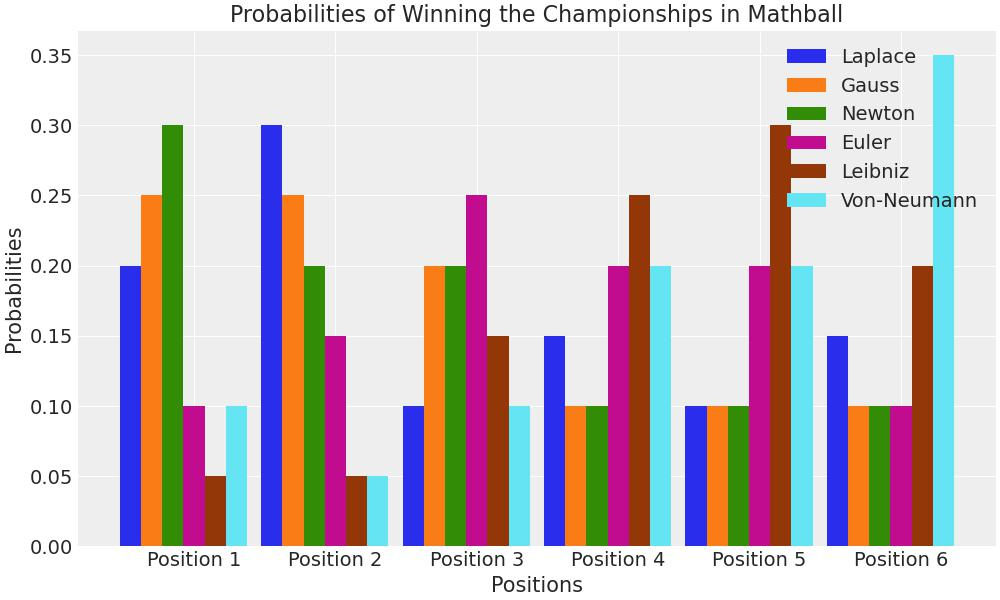

In [61]:
from IPython.display import Image, display
image_path = 'img_bar_chat.jpg'
display(Image(filename=image_path))

## Your code and answers here

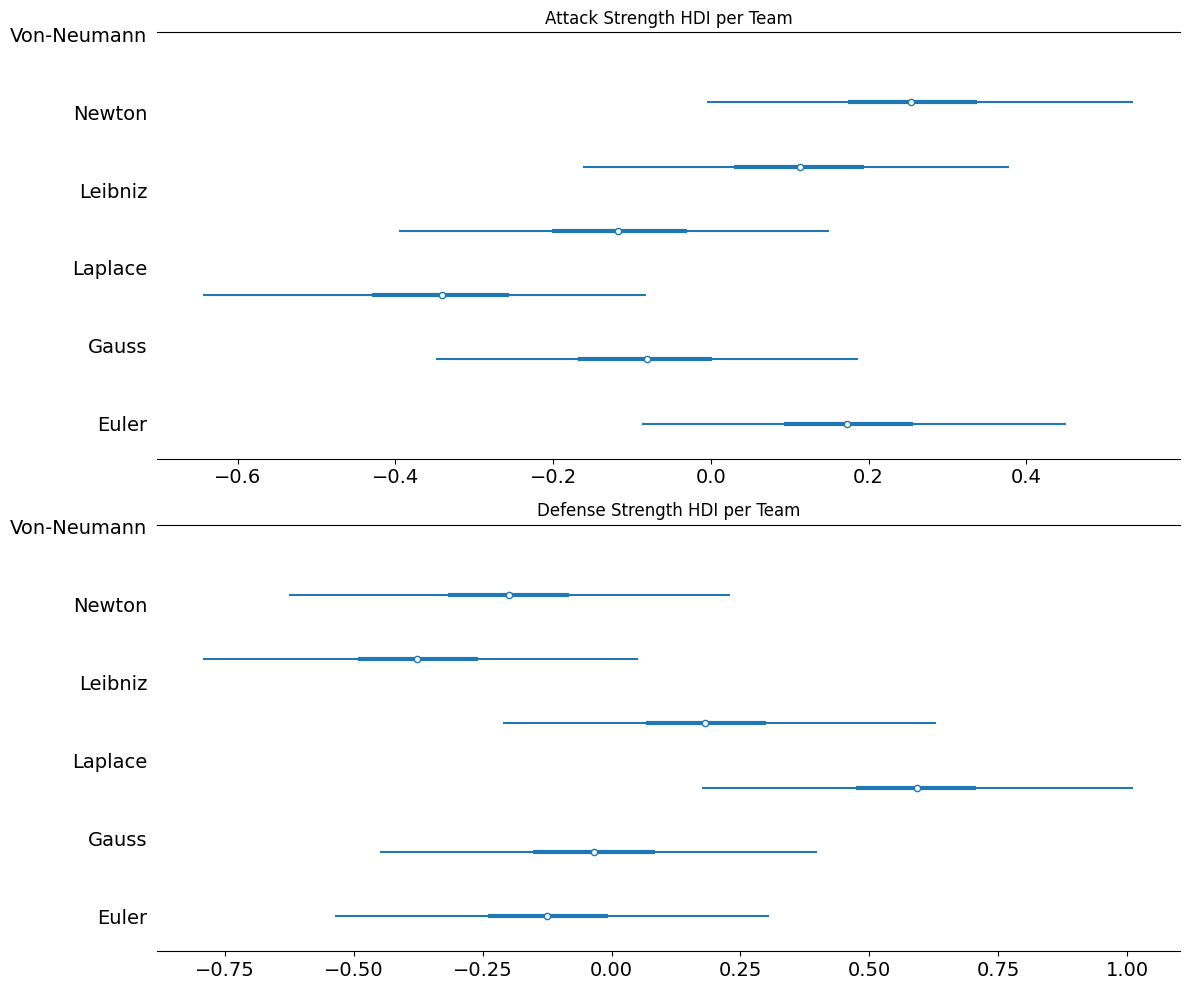

Best offense: Euler
Worst offense: Leibniz
Best defense: Leibniz
Worst defense: Gauss


In [62]:
import arviz as az
import matplotlib.pyplot as plt

# Extract attack and defense strengths from the trace
att_samples = trace.posterior['att']
def_samples = trace.posterior['def']

# Plot HDI (Highest Density Interval) for attack and defense
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

az.plot_forest(trace, var_names=['att'], hdi_prob=0.95, combined=True, ax=axs[0])
axs[0].set_title('Attack Strength HDI per Team')
axs[0].set_yticks(range(len(teams)))
axs[0].set_yticklabels(teams)

az.plot_forest(trace, var_names=['def'], hdi_prob=0.95, combined=True, ax=axs[1])
axs[1].set_title('Defense Strength HDI per Team')
axs[1].set_yticks(range(len(teams)))
axs[1].set_yticklabels(teams)

plt.tight_layout()
plt.show()

# Identify best and worst offense and defense
att_mean = att_samples.mean(dim=("chain", "draw")).values
def_mean = def_samples.mean(dim=("chain", "draw")).values

best_offense_idx = att_mean.argmax()
worst_offense_idx = att_mean.argmin()
best_defense_idx = def_mean.argmax()
worst_defense_idx = def_mean.argmin()

best_offense = teams[best_offense_idx]
worst_offense = teams[worst_offense_idx]
best_defense = teams[best_defense_idx]
worst_defense = teams[worst_defense_idx]

print(f"Best offense: {best_offense}")
print(f"Worst offense: {worst_offense}")
print(f"Best defense: {best_defense}")
print(f"Worst defense: {worst_defense}")


In [63]:
# Extract samples for Euler and Gauss defense
def_euler = def_samples.sel(team='Euler')
def_gauss = def_samples.sel(team='Gauss')

# Calculate the probability
prob_euler_better_def = (def_euler > def_gauss).mean().values
print(f"Probability that Euler has a better defense than Gauss: {prob_euler_better_def:.2f}")

Probability that Euler has a better defense than Gauss: 0.98


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import scipy

# Extract posterior samples
posterior = az.extract(trace)

# Function to calculate game probabilities
def calculate_game_probabilities(home_team, away_team, posterior, threshold=20):
    home_idx = teams.get_loc(home_team)
    away_idx = teams.get_loc(away_team)
    
    # Calculate rates
    home_rate = np.exp(posterior['intercept'] + posterior['home'] + 
                       posterior['att'][:, home_idx] - posterior['att'].mean(axis=1) + 
                       posterior['def'][:, away_idx] - posterior['def'].mean(axis=1))
    away_rate = np.exp(posterior['intercept'] + 
                       posterior['att'][:, away_idx] - posterior['att'].mean(axis=1) + 
                       posterior['def'][:, home_idx] - posterior['def'].mean(axis=1))
    
    # Calculate probabilities
    home_prob = (1 - scipy.stats.poisson.cdf(threshold - 1, home_rate)).mean()
    away_prob = scipy.stats.poisson.cdf(threshold - 1, away_rate).mean()
    
    return home_prob, away_prob

# Calculate probabilities for Leibniz (home) vs Newton (away)
leibniz_prob, newton_prob = calculate_game_probabilities('Leibniz', 'Newton', posterior)

print(f"Probability that Leibniz will score more than 20: {leibniz_prob:.2f}")
print(f"Probability that Newton will score less than 20: {newton_prob:.2f}")

Probability that Leibniz will score more than 20: 0.65
Probability that Newton will score less than 20: 0.85


In [96]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

with mathball:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y1", "y2"])

# Step 2: Calculate points for each game
def calculate_points(y1, y2):
    points_home = np.where(y1 > y2, 3, np.where(y1 == y2, 1, 0))
    points_away = np.where(y1 < y2, 3, np.where(y1 == y2, 1, 0))
    return points_home, points_away

points_home, points_away = calculate_points(ppc.posterior_predictive['y1'], ppc.posterior_predictive['y2'])

# Step 3: Aggregate points and rank teams
# Assuming 'teams' is an array of team names corresponding to the indices in 'y1' and 'y2'
total_points = points_home.sum(axis=0) + points_away.sum(axis=0)
rankings = np.argsort(-total_points)  # Negative for descending order

# Step 4: Calculate rank probabilities
# This is a simplified approach; for detailed analysis, consider each team's rank across all simulations
rank_probabilities = pd.DataFrame(index=teams, columns=np.arange(1, len(teams) + 1), data=0)
for i, team in enumerate(teams):
    team_rank = np.where(rankings == i)[0] + 1  # Ranks are 1-indexed
    rank_probabilities.loc[team, team_rank] = 1

# Step 5: Visualize rank probabilities
fig, ax = plt.subplots(figsize=(10, 6))
rank_probabilities.T.plot(kind='bar', stacked=False, ax=ax)
plt.title('Probabilities of Winning the Championships in Mathball')
plt.xlabel('Positions')
plt.ylabel('Probabilities')

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 1.0))

# Adjust layout to avoid overlapping labels
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin for better legend fit

plt.show()

Sampling: [y1, y2]


Output()

KeyError: 31

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'ppc' contains the simulated game outcomes ('y1' and 'y2' for home and away scores respectively)

# Step 2: Calculate points for each game
def calculate_points(y1, y2):
    points_home = np.where(y1 > y2, 3, np.where(y1 == y2, 1, 0))
    points_away = np.where(y1 < y2, 3, np.where(y1 == y2, 1, 0))
    return points_home, points_away

points_home, points_away = calculate_points(ppc.posterior_predictive['y1'], ppc.posterior_predictive['y2'])

# Step 3: Aggregate points and rank teams
# Assuming 'teams' is an array of team names corresponding to the indices in 'y1' and 'y2'
total_points = points_home.sum(axis=0) + points_away.sum(axis=0)
rankings = np.argsort(-total_points)  # Negative for descending order

# Step 4: Calculate rank probabilities
# This is a simplified approach; for detailed analysis, consider each team's rank across all simulations
rank_probabilities = pd.DataFrame(index=teams, columns=np.arange(1, len(teams) + 1), data=0)
for i, team in enumerate(teams):
    team_rank = np.where(rankings == i)[0] + 1  # Ranks are 1-indexed
    rank_probabilities.loc[team, team_rank] = 1

# Step 5: Visualize rank probabilities
rank_probabilities.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Probability of Each Rank for Each Team')
plt.xlabel('Team')
plt.ylabel('Probability')
plt.legend(title='Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()